In [ ]:
#Import Libraries
import torch
import time
import math
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from collections import Counter
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Task 1 : Data Preparation

In [ ]:
# Load the dataset from huggingface
dataset = load_dataset("google/code_x_glue_cc_code_completion_token", "python")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

README.md: 0.00B [00:00, ?B/s]

python/train-00000-of-00002.parquet:   0%|          | 0.00/70.1M [00:00<?, ?B/s]

python/train-00001-of-00002.parquet:   0%|          | 0.00/70.9M [00:00<?, ?B/s]

python/test-00000-of-00001.parquet:   0%|          | 0.00/69.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_dataset.column_names

['id', 'path', 'code']

## Preprocessing

In [ ]:
# Build vocabulary by counting token frequencies across the training dataset
counter = Counter()
for row in train_dataset:
  tokens = row["code"]
  counter.update(tokens)

In [ ]:
# Create a vocabulary of the 10,000 most frequent tokens plus special tokens
# <PAD> for padding shorter sequences, <UNK> for unknown/rare tokens
MAX_VOCAB_SIZE = 10000
OOV_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"
most_common = counter.most_common(MAX_VOCAB_SIZE)
vocab_tokens = [tok for tok, _ in most_common]

vocab = [PAD_TOKEN, OOV_TOKEN] + vocab_tokens
token_to_id = {tok: idx for idx, tok in enumerate(vocab)}

In [ ]:
top_5 = vocab[:10]
last_5 = vocab[-10:]

df = pd.DataFrame({
    "Top 10 tokens": top_5,
    "Last 10 tokens": last_5
})

print(df.to_string(index=False))

Top 10 tokens       Last 10 tokens
        <PAD>           parse_json
        <UNK>   MethodNotSupported
        <EOL>        ClientMessage
            . driver_internal_info
            (                  Avg
            )              collada
            ,               scales
            =                 ofpp
            :                 p_mi
         self               'copy'


## Sequencing

In [ ]:
# Convert tokens to numerical IDs and pad sequences to fixed length

MAX_SEQ_LEN = 1000
def encode_and_pad(row):
  tokens = row["code"]

  ids = [ token_to_id.get(tok, token_to_id[OOV_TOKEN]) for tok in tokens ]
  if len(ids) > MAX_SEQ_LEN:
    ids = ids[:MAX_SEQ_LEN]  
  else:
    ids += [token_to_id[PAD_TOKEN]] * (MAX_SEQ_LEN - len(ids))  
  return {"input_ids": ids}

In [ ]:
train_encoded = train_dataset.map(
    encode_and_pad,
    remove_columns=train_dataset.column_names,
    num_proc=4
)

test_encoded = test_dataset.map(
    encode_and_pad,
    remove_columns=test_dataset.column_names,
    num_proc=2
)

Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50000 [00:00<?, ? examples/s]

## Create Validation Split

In [ ]:
VALIDATION_SPLIT = 0.2
RANDOM_SEED = 42
split       = train_encoded.train_test_split(
                  test_size=VALIDATION_SPLIT,
                  seed=RANDOM_SEED
              )
train_final = split["train"]
val_final   = split["test"]

## Pytorch Dataloaders

In [ ]:
class CodeTokensDataset(Dataset):
  def __init__(self, hf_dataset):
    self.dataset = hf_dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    input_ids = torch.tensor(item["input_ids"], dtype = torch.long)
    # Input: all tokens except the last, Target: all tokens except the first
    return input_ids[:-1], input_ids[1:]

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(
    CodeTokensDataset(train_final),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    CodeTokensDataset(val_final),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    CodeTokensDataset(test_encoded),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
x, y = next(iter(train_loader))
print("Batch input shape:", x.shape)
print("Batch target shape:", y.shape)

Batch input shape: torch.Size([32, 999])
Batch target shape: torch.Size([32, 999])


# Task 2 : Baseline Models

## Model Implementation

In [ ]:
# Vanilla RNN model 
class RNNModel(nn.Module):
  def __init__(
      self,
      vocab_size: int,
      embedding_dim: int = 256,
      hidden_dim: int = 512,
      num_layers: int = 2,
      dropout: float = 0.3,
      nonlinearity: str = "tanh"
  ):

    super().__init__()
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
    # RNN Layer
    self.rnn = nn.RNN(
        input_size = embedding_dim,
        hidden_size = hidden_dim,
        num_layers = num_layers,
        batch_first = False,  # Sequence-first 
        dropout = dropout,
        nonlinearity = nonlinearity
    )

    self.dropout = nn.Dropout(dropout)
    # Output Layer
    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, x):
    # Transpose to sequence-first format
    x = x.transpose(0,1)
    emb = self.embedding(x)
    output, hidden = self.rnn(emb)
    output = self.dropout(output)
    logits = self.fc(output)
    # Transpose back to batch-first format
    logits = logits.transpose(0,1)
    return logits, hidden

In [ ]:
# LSTM model 
class LSTMModel(nn.Module):
  def __init__(
      self,
      vocab_size: int,
      embedding_dim: int = 256,
      hidden_dim: int = 512,
      num_layers: int = 2,
      dropout: float = 0.3
  ):
    super().__init__()
    # Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
    # LSTM layers
    self.lstm = nn.LSTM(
        input_size = embedding_dim,
        hidden_size = hidden_dim,
        num_layers = num_layers,
        batch_first = False,
        dropout = dropout
    )

    self.dropout = nn.Dropout(dropout)
    # Output Layer
    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(
      self,
      x: torch.Tensor,
      hidden: torch.Tensor = None,
      cell: torch.Tensor = None
  ):
    x = x.transpose(0,1)  
    emb = self.embedding(x)
    output, (hidden, cell) = self.lstm(emb, (hidden, cell) if (hidden is not None and cell is not None) else None)
    output = self.dropout(output)
    logits = self.fc(output)
    logits = logits.transpose(0,1)  # Back to batch-first
    return logits, (hidden, cell)

## Training & Validation

In [ ]:
# Calculate Top-K accuracy
def top_k_accuracy(logits, targets, k=5, ignore_index=0):
  #print(logits.shape)
  B, T, V = logits.shape
  logits_flat = logits.reshape(-1, V)
  targets_flat = targets.reshape(-1)
  #print(target_flat)
  # Ignore padding tokens in accuracy calculation
  mask = targets_flat.ne(ignore_index)

  if mask.sum().item() == 0:
    return torch.tensor(0.0, device=logits.device)

  # Get top-k predictions for each position
  topk = logits_flat.topk(k, dim = -1).indices #(B*T, K)
  correct = topk.eq(targets_flat.unsqueeze(-1))
  correct_any = correct.any(dim = -1).float() #(B*T,)
  # Average only over non-padding positions
  acc = correct_any[mask].mean()
  return acc.item()

In [ ]:
# evaluation function for model performance
def evaluate(model, dataloader, criterion, device, pad_idx):
  model.eval()  # Disable dropout
  total_loss = 0.0
  total_tokens = 0
  total_ppl_loss = 0.0
  total_top5 = 0.0

  with torch.no_grad():  # Disable gradient computation for efficiency
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      logits, _ = model(x)
      B, T, V = logits.shape
      logits_flat = logits.reshape(-1, V)
      targets_flat = y.reshape(-1)
      loss = criterion(logits_flat, targets_flat)
      #print(loss)
      # Only count non-padding tokens in our metrics
      non_pad = targets_flat.ne(pad_idx).sum().item()
      total_loss += loss.item() * non_pad
      total_tokens += non_pad
      total_ppl_loss += loss.item() * non_pad
      top5 = top_k_accuracy(logits, y, k = 5, ignore_index=pad_idx)
      total_top5 += top5 * non_pad

  # Calculate final metrics
  avg_loss = total_loss / total_tokens
  perplexity = math.exp(total_ppl_loss / total_tokens)  # Lower is better
  top5_acc = total_top5 / total_tokens

  return avg_loss, perplexity, top5_acc

In [ ]:
def plot_history(history, plot_path):
  epochs = range(1, len(history['train_loss']) + 1)
  plt.figure(figsize=(14,6))

  plt.subplot(2,2,1)
  plt.plot(epochs, history["val_top5"], label="Top-5 Acc")
  plt.xlabel("Epoch"); plt.ylabel("Top-5 Accuracy")
  plt.grid(True)

  plt.subplot(2,2,2)
  plt.plot(epochs, history["val_ppl"], label="Perplexity", color="orange")
  plt.xlabel("Epoch"); plt.ylabel("Perplexity")
  plt.grid(True)

  plt.subplot(2,2,3)
  plt.plot(epochs, history["epoch_time"], label="Seconds/Epoch", color="green")
  plt.xlabel("Epoch"); plt.ylabel("Time (s)")
  plt.grid(True)

  plt.subplot(2,2,4)
  plt.plot(epochs, np.array(history["throughput"])/1000,
            label="Throughput (K tok/s)", color="red")
  plt.xlabel("Epoch"); plt.ylabel("K Tokens/s")
  plt.grid(True)

  plt.tight_layout()
  plt.savefig(plot_path)
  print(f"\nSaved training curves (accuracy, PPL, time, throughput) to {plot_path}")

In [ ]:
# Main training loop 
# Evaluates on validation set, and saves the best model
def train_loop(model, train_loader, val_loader, config):
  device = config["device"]
  model.to(device)

  pad_idx = token_to_id[PAD_TOKEN]
  # Cross-entropy loss, ignoring padding tokens
  criterion = nn.CrossEntropyLoss(ignore_index = pad_idx, reduction = "mean")
  optimizer = optim.Adam(model.parameters(), lr = config["lr"])

  best_val_loss = float("inf")
  # Track training metrics over time
  history = {"train_loss": [], "val_loss": [], "val_ppl":[], "val_top5": [], "epoch_time": [], "throughput": []}

  total_start_time = time.perf_counter()

  for epoch in range(1, config["epochs"] + 1):
    model.train()  # Enables dropout
    epoch_loss = 0.0
    epoch_tokens = 0
    start_time = time.perf_counter()

    # Training phase
    for x, y in train_loader:
      x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      logits, _ = model(x)
      B, T, V = logits.shape
      logits_flat = logits.reshape(-1, V)
      targets_flat = y.reshape(-1)
      loss = criterion(logits_flat, targets_flat)
      #Backprop
      loss.backward()
      optimizer.step()

      non_pad = targets_flat.ne(pad_idx).sum().item()
      epoch_loss += loss.item() * non_pad
      epoch_tokens += non_pad

    elapsed = time.perf_counter() - start_time
    secs_per_epoch = elapsed
    tok_per_sec    = epoch_tokens / elapsed

    train_loss = epoch_loss / epoch_tokens

    # Evaluate on validation set
    val_loss, val_ppl, val_top5 = evaluate(model, val_loader, criterion, device, pad_idx)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_ppl"].append(val_ppl)
    history["val_top5"].append(val_top5)
    history["epoch_time"].append(secs_per_epoch)
    history["throughput"].append(tok_per_sec)

    print(f"Epoch {epoch:>2}/{config['epochs']:<2} │ "
      f"Train Loss: {train_loss:.4f} │ "
      f"Val Loss: {val_loss:.4f} │ "
      f"Val PPL: {val_ppl:.2f} │ "
      f"Val Top-5 Acc: {val_top5*100:.2f}% │ "
      f"Time: {secs_per_epoch:.1f}s │ "
      f"Throughput: {tok_per_sec/1000:.1f}K tok/s")

    # Save best model based on validation loss
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model, config["save_path"])
      #print("saved")

  total_time = time.perf_counter() - total_start_time
  total_hours = int(total_time // 3600)
  total_minutes = int((total_time % 3600) // 60)
  total_seconds = int(total_time % 60)

  print(f"\nTotal training time: {total_hours}h {total_minutes}m {total_seconds}s")

  # Generate training curves visualization
  plot_history(history, config["plot_path"])

  return history

In [ ]:
config = {
    "model": "rnn",
    "epochs": 10,
    "lr": 1e-3,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_path": "best_rnn_model.pt",
    "plot_path": "val_metrics_rnn.png",
}

In [ ]:
vocab_size = len(token_to_id)
vocab_size

10002

Training RNN model on cuda for 10 epochs...


Epoch  1/10 │ Train Loss: 2.3486 │ Val Loss: 2.0253 │ Val PPL: 7.58 │ Val Top-5 Acc: 81.14% │ Time: 703.5s │ Throughput: 50.5K tok/s


Epoch  2/10 │ Train Loss: 2.0658 │ Val Loss: 1.9485 │ Val PPL: 7.02 │ Val Top-5 Acc: 81.95% │ Time: 704.2s │ Throughput: 50.5K tok/s


Epoch  3/10 │ Train Loss: 1.9997 │ Val Loss: 1.9031 │ Val PPL: 6.71 │ Val Top-5 Acc: 82.40% │ Time: 704.5s │ Throughput: 50.4K tok/s


Epoch  4/10 │ Train Loss: 2.0081 │ Val Loss: 1.9886 │ Val PPL: 7.31 │ Val Top-5 Acc: 81.52% │ Time: 704.0s │ Throughput: 50.5K tok/s


Epoch  5/10 │ Train Loss: 2.0836 │ Val Loss: 1.9740 │ Val PPL: 7.20 │ Val Top-5 Acc: 81.73% │ Time: 703.9s │ Throughput: 50.5K tok/s


Epoch  6/10 │ Train Loss: 2.0677 │ Val Loss: 2.0325 │ Val PPL: 7.63 │ Val Top-5 Acc: 81.14% │ Time: 704.2s │ Throughput: 50.5K tok/s


Epoch  7/10 │ Train Loss: 2.0517 │ Val Loss: 1.9166 │ Val PPL: 6.80 │ Val Top-5 Acc: 82.31% │ Time: 703.5s │ Throughput: 50.5K tok/s


Epoch  8/10 │ Train Loss: 2.0919 │ Val Loss: 2.0375 │ Val PPL: 7.67 │ Val Top-5 Acc: 81.13% │ Time: 703.5s │ Throughput: 50.5K tok/s


Epoch  9/10 │ Train Loss: 2.0748 │ Val Loss: 1.9468 │ Val PPL: 7.01 │ Val Top-5 Acc: 81.96% │ Time: 702.8s │ Throughput: 50.6K tok/s


Epoch 10/10 │ Train Loss: 2.1190 │ Val Loss: 1.9860 │ Val PPL: 7.29 │ Val Top-5 Acc: 81.59% │ Time: 702.8s │ Throughput: 50.6K tok/s

Total training time: 2h 10m 52s

Saved training curves (accuracy, PPL, time, throughput) to val_metrics_rnn.png


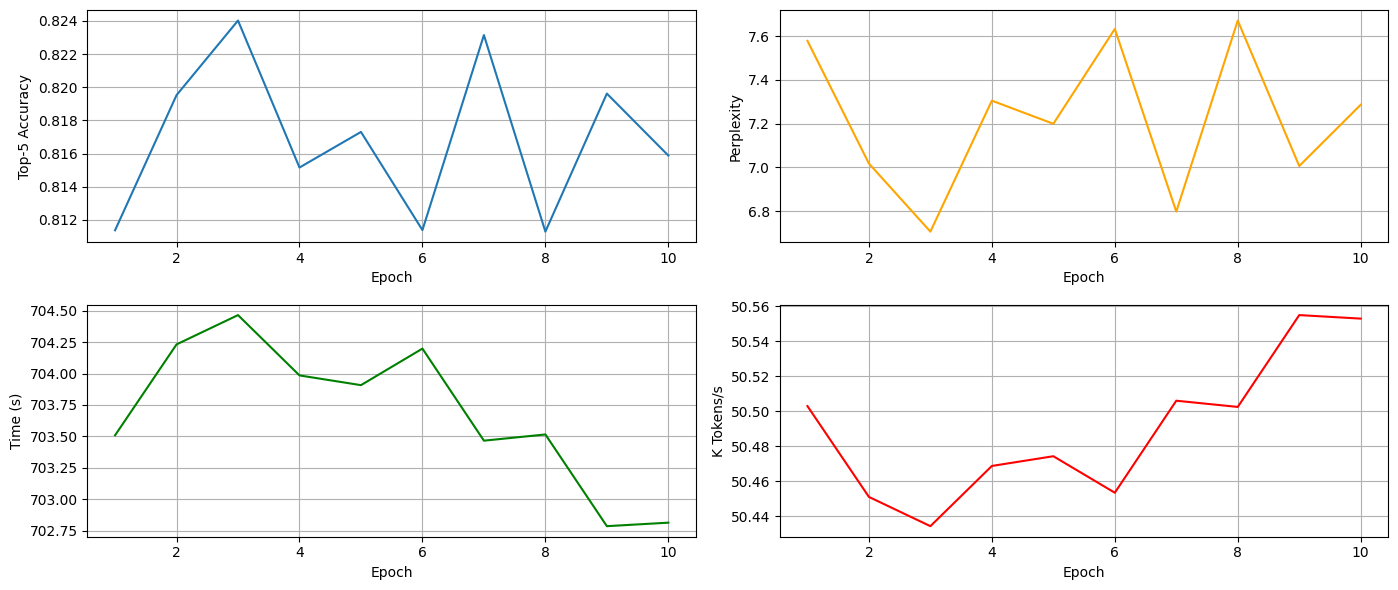

In [ ]:
if config["model"] == "rnn":
    model = RNNModel(vocab_size)
else:
    model = LSTMModel(vocab_size)

print(f"Training {config['model'].upper()} model on {config['device']} for {config['epochs']} epochs...")
history = train_loop(model, train_loader, val_loader, config)

In [ ]:
config = {
    "model": "lstm",
    "epochs": 10,
    "lr": 1e-3,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_path": "best_lstm_model.pt",
    "plot_path": "val_metrics_lstm.png",
}

Training LSTM model on cuda for 10 epochs...


Epoch  1/10 │ Train Loss: 2.6310 │ Val Loss: 2.0138 │ Val PPL: 7.49 │ Val Top-5 Acc: 81.13% │ Time: 989.2s │ Throughput: 35.9K tok/s


Epoch  2/10 │ Train Loss: 1.9318 │ Val Loss: 1.7650 │ Val PPL: 5.84 │ Val Top-5 Acc: 83.86% │ Time: 988.6s │ Throughput: 35.9K tok/s


Epoch  3/10 │ Train Loss: 1.7482 │ Val Loss: 1.6327 │ Val PPL: 5.12 │ Val Top-5 Acc: 85.36% │ Time: 990.5s │ Throughput: 35.9K tok/s


Epoch  4/10 │ Train Loss: 1.6400 │ Val Loss: 1.5504 │ Val PPL: 4.71 │ Val Top-5 Acc: 86.29% │ Time: 989.2s │ Throughput: 35.9K tok/s


Epoch  5/10 │ Train Loss: 1.5662 │ Val Loss: 1.4974 │ Val PPL: 4.47 │ Val Top-5 Acc: 86.91% │ Time: 989.5s │ Throughput: 35.9K tok/s


Epoch  6/10 │ Train Loss: 1.5124 │ Val Loss: 1.4552 │ Val PPL: 4.29 │ Val Top-5 Acc: 87.38% │ Time: 989.3s │ Throughput: 35.9K tok/s


Epoch  7/10 │ Train Loss: 1.4711 │ Val Loss: 1.4260 │ Val PPL: 4.16 │ Val Top-5 Acc: 87.73% │ Time: 991.5s │ Throughput: 35.8K tok/s


Epoch  8/10 │ Train Loss: 1.4387 │ Val Loss: 1.4039 │ Val PPL: 4.07 │ Val Top-5 Acc: 87.98% │ Time: 1007.9s │ Throughput: 35.2K tok/s


Epoch  9/10 │ Train Loss: 1.4124 │ Val Loss: 1.3838 │ Val PPL: 3.99 │ Val Top-5 Acc: 88.22% │ Time: 1005.7s │ Throughput: 35.3K tok/s


Epoch 10/10 │ Train Loss: 1.3919 │ Val Loss: 1.3683 │ Val PPL: 3.93 │ Val Top-5 Acc: 88.39% │ Time: 1005.3s │ Throughput: 35.3K tok/s

Total training time: 3h 4m 25s

Saved training curves (accuracy, PPL, time, throughput) to val_metrics_lstm.png


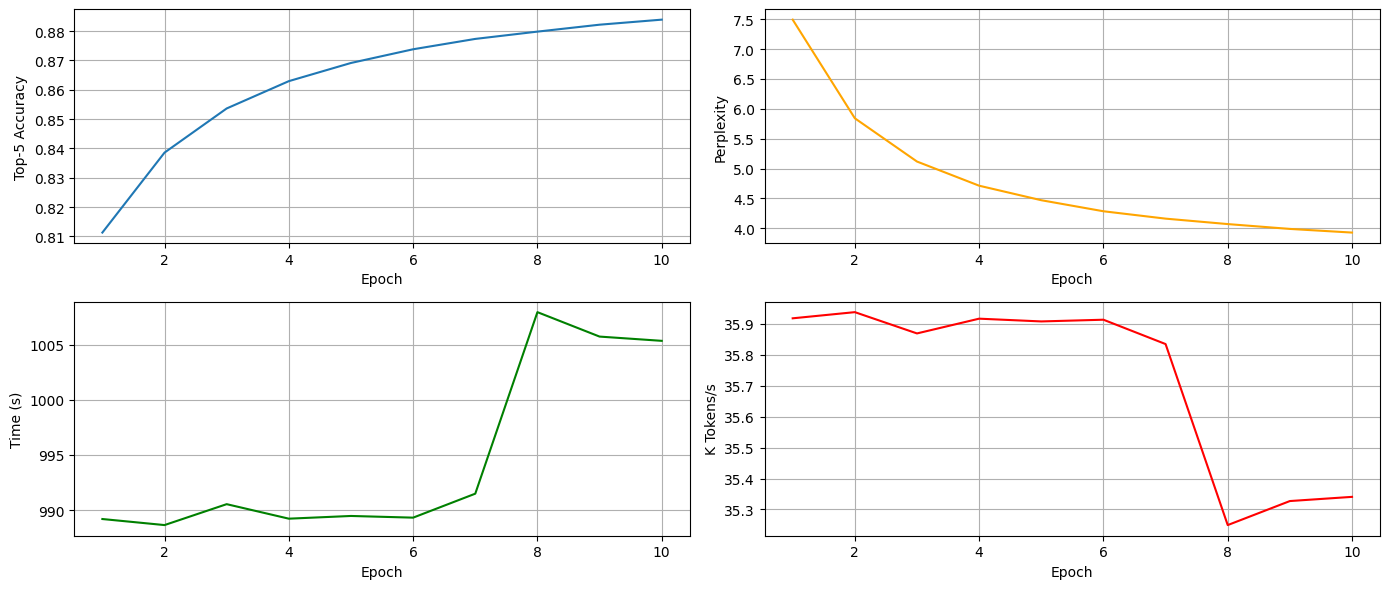

In [ ]:
if config["model"] == "rnn":
    model = RNNModel(vocab_size)
else:
    model = LSTMModel(vocab_size)

print(f"Training {config['model'].upper()} model on {config['device']} for {config['epochs']} epochs...")
history = train_loop(model, train_loader, val_loader, config)

## Final Evaluation

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def load_model(checkpoint_path, device):
    model = torch.load(checkpoint_path, map_location=device, weights_only = False)
    model.to(device)
    model.eval()
    return model

In [ ]:
# Final evaluation: Load best saved models and test on held-out test set
pad_idx = token_to_id[PAD_TOKEN]
vocab_size = len(token_to_id)

criterion = nn.CrossEntropyLoss(ignore_index = pad_idx, reduction = "mean")


rnn = load_model("best_rnn_model.pt", device)
lstm = load_model("best_lstm_model.pt", device)


rnn_loss, rnn_ppl, rnn_top5 = evaluate(rnn, test_loader, criterion, device, pad_idx)
#print("RNN Done")
lstm_loss, lstm_ppl, lstm_top5 = evaluate(lstm, test_loader, criterion, device, pad_idx)


rnn_params  = count_parameters(rnn)
lstm_params = count_parameters(lstm)


print("\nFinal Test Evaluation\n" + "="*25)
header = f"{'Model':<10} {'#Params':>12} {'Top-5 Acc':>12} {'Perplexity':>12}"
print(header)
print("-"*len(header))
print(f"{'RNN':<10} {rnn_params:12,d} {rnn_top5*100:11.2f}% {rnn_ppl:12.2f}")
print(f"{'LSTM':<10} {lstm_params:12,d} {lstm_top5*100:11.2f}% {lstm_ppl:12.2f}\n")


Final Test Evaluation
Model           #Params    Top-5 Acc   Perplexity
-------------------------------------------------
RNN           8,611,090       82.49%         6.63
LSTM         11,369,746       88.48%         3.89



# Task 3 : Residual Recurrent Models

## Implementation

In [ ]:
# Residual LSTM model: Two LSTM layers with skip connections
class ResidualLSTMModel(nn.Module):
  def __init__(
      self,
      vocab_size: int,
      embedding_dim: int = 256,
      hidden_dim: int = 512,
      dropout: float = 0.3
  ):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
    
    # First LSTM layer
    self.lstm1 = nn.LSTM(
        input_size = embedding_dim,
        hidden_size = hidden_dim,
        num_layers = 1,
        batch_first = False
    )
    # Second LSTM layer
    self.lstm2 = nn.LSTM(
        input_size = hidden_dim,
        hidden_size = hidden_dim,
        num_layers = 1,
        dropout = dropout,
        batch_first = False
    )
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(
      self,
      x: torch.Tensor,
      h1: torch.Tensor = None,
      c1: torch.Tensor = None,
      h2: torch.Tensor = None,
      c2: torch.Tensor = None,
  ):
    x = x.transpose(0,1)
    emb = self.embedding(x)
    out1, (h1_new, c1_new) = self.lstm1(emb, (h1, c1) if h1 is not None else None)

    out2, (h2_new, c2_new) = self.lstm2(out1, (h2, c2) if h2 is not None else None)
    
    # Residual connection
    res = out1 + out2
    res = self.dropout(res)

    logits = self.fc(res)
    logits = logits.transpose(0,1)
    return logits, (h1_new, c1_new, h2_new, c2_new)

## Training

In [ ]:
config = {
    "model": "residual_lstm",
    "epochs": 10,
    "lr": 1e-3,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_path": "best_residual_model.pt",
    "plot_path": "val_metrics_residual.png",
}

Training RESIDUAL_LSTM model on cuda for 10 epochs...


Epoch  1/10 │ Train Loss: 2.0956 │ Val Loss: 1.7072 │ Val PPL: 5.51 │ Val Top-5 Acc: 84.84% │ Time: 1006.6s │ Throughput: 35.3K tok/s


Epoch  2/10 │ Train Loss: 1.6334 │ Val Loss: 1.5239 │ Val PPL: 4.59 │ Val Top-5 Acc: 86.82% │ Time: 1006.4s │ Throughput: 35.3K tok/s


Epoch  3/10 │ Train Loss: 1.4898 │ Val Loss: 1.4344 │ Val PPL: 4.20 │ Val Top-5 Acc: 87.78% │ Time: 1006.4s │ Throughput: 35.3K tok/s


Epoch  4/10 │ Train Loss: 1.4067 │ Val Loss: 1.3863 │ Val PPL: 4.00 │ Val Top-5 Acc: 88.31% │ Time: 1006.2s │ Throughput: 35.3K tok/s


Epoch  5/10 │ Train Loss: 1.3512 │ Val Loss: 1.3495 │ Val PPL: 3.86 │ Val Top-5 Acc: 88.74% │ Time: 1007.2s │ Throughput: 35.3K tok/s


Epoch  6/10 │ Train Loss: 1.3109 │ Val Loss: 1.3285 │ Val PPL: 3.78 │ Val Top-5 Acc: 88.98% │ Time: 1006.1s │ Throughput: 35.3K tok/s


Epoch  7/10 │ Train Loss: 1.2796 │ Val Loss: 1.3131 │ Val PPL: 3.72 │ Val Top-5 Acc: 89.16% │ Time: 1007.2s │ Throughput: 35.3K tok/s


Epoch  8/10 │ Train Loss: 1.2543 │ Val Loss: 1.3003 │ Val PPL: 3.67 │ Val Top-5 Acc: 89.32% │ Time: 1006.7s │ Throughput: 35.3K tok/s


Epoch  9/10 │ Train Loss: 1.2341 │ Val Loss: 1.3067 │ Val PPL: 3.69 │ Val Top-5 Acc: 89.25% │ Time: 1007.8s │ Throughput: 35.3K tok/s


Epoch 10/10 │ Train Loss: 1.2160 │ Val Loss: 1.2849 │ Val PPL: 3.61 │ Val Top-5 Acc: 89.50% │ Time: 1007.3s │ Throughput: 35.3K tok/s

Total training time: 3h 8m 6s

Saved training curves (accuracy, PPL, time, throughput) to val_metrics_residual.png


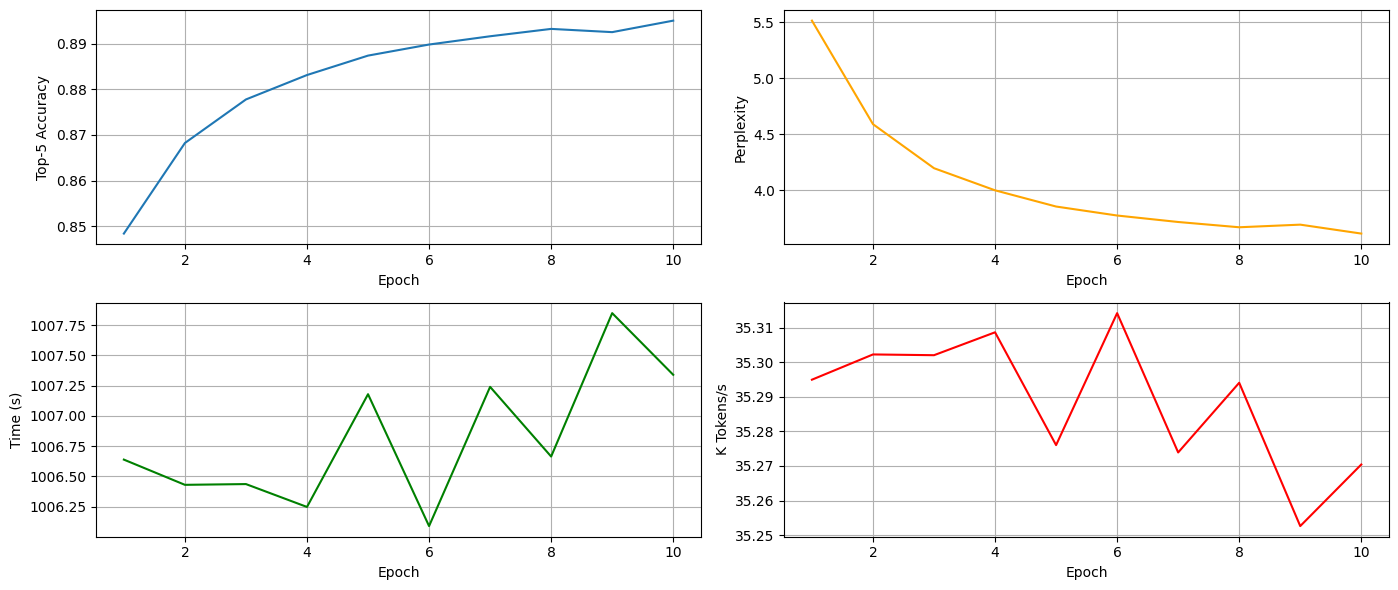

In [ ]:
model = ResidualLSTMModel(vocab_size)
print(f"Training {config['model'].upper()} model on {config['device']} for {config['epochs']} epochs...")
history = train_loop(model, train_loader, val_loader, config)

## Evaluation

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def load_model(checkpoint_path, device):
    model = torch.load(checkpoint_path, map_location=device, weights_only = False)
    model.to(device)
    model.eval()
    return model

In [ ]:
# Evaluate the residual LSTM model 
pad_idx = token_to_id[PAD_TOKEN]
vocab_size = len(token_to_id)

criterion = nn.CrossEntropyLoss(ignore_index = pad_idx, reduction = "mean")
residual_lstm = load_model("best_residual_model.pt", device)
residual_lstm_loss, residual_lstm_ppl, residual_lstm_top5 = evaluate(residual_lstm, test_loader, criterion, device, pad_idx)
#print("Eval done")
residual_lstm_params = count_parameters(residual_lstm)

print("\nFinal Test Evaluation")
print("=" * 25)
header = f"{'Model':<20} {'#Params':>12} {'Top-5 Acc':>12} {'Perplexity':>12}"
print(header)
print("-" * len(header))
print(f"{'Residual LSTM':<20} {residual_lstm_params:12,d} {residual_lstm_top5*100:11.2f}% {residual_lstm_ppl:12.2f}")
print(f"{'LSTM':<20} {lstm_params:12,d} {lstm_top5*100:11.2f}% {lstm_ppl:12.2f}")


Final Test Evaluation
Model                     #Params    Top-5 Acc   Perplexity
-----------------------------------------------------------
Residual LSTM          11,369,746       89.59%         3.58
LSTM                   11,369,746       88.48%         3.89
